# Collapsing of frequency magnitude distributions for Nath & Thingbaijam (2012)

OpenQuake isn't up to the task of enumerating $3^{222} \approx 0.83$ million
googols of logic tree branches, so we will collapse all $m_{max}$ and $b$
variation for each areal zone into one discrete distribution.

Note: For imports to work, ../utilities directory must be added to PYTHONPATH

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from IPython.display import display

from toolbox import annotate
from logic_tree_tools import read_tree_tsv, collapse_sources
from source_model_tools import csv2areal

%matplotlib inline

In [2]:
LAYERS_DF = pd.read_csv('layers.csv', index_col='layerid')
USE_RECOMPUTED = False

model_path = '../Data/nath2012probabilistic'
if USE_RECOMPUTED:
    smoothed_model_path = '../Smoothed/Recomputed'
else:
    smoothed_model_path = model_path

smoothed_source_data_file = 'smoothed_source_model'

In [3]:
areal_source_model_csv = 'areal_source_model.csv'
min_mags = [4.5, 5.5]
smoothed_source_models_csv = [
    'nath2012probabilistic_smoothed_source_model_mmin_%g.csv' % min_mag
    for min_mag in min_mags]
source_tree_tsv = '../Logic Trees/areal_model_logic_tree.tsv'

# Read model data

In [4]:
areal_df = csv2areal(areal_source_model_csv)

display_drop = [column for column in areal_df if column in
                ['polygon', 'geometry', 'aspect ratio', 'centroid',
                 'source_name', 'id', 'concerns', 'mmin']]
display_drop += [column for column in areal_df if column.endswith('2')]

display(pd.concat([areal_df.drop(display_drop, axis=1).head(),
                   areal_df.drop(display_drop, axis=1).tail()]))

Reading:
	/home/nick/Desktop/indian-subcontinent-psha/Source Models/areal_source_model.csv


,layerid,a,b,stdb,mmax,stdmmax,strike,dip,rake,msr,tectonic zone,region,tectonic subregion,zmin,zmax,mechanism,new style
zoneid,,,,,,,,,,,,,,,,,
1,1,5.20,1.05,0.07,8.0,0.4,202.0,73.0,30.0,StrasserInterface,Subduction interface,Pamirs,subduction interface,0.0,25.0,dextral,strike-slip
2,1,4.64,0.93,0.09,8.0,0.4,306.0,31.0,142.0,StrasserInterface,Subduction interface,Pamirs,subduction interface,0.0,25.0,reverse,reverse
3,1,3.75,0.77,0.05,8.0,0.4,59.0,89.0,33.0,WC1994,Active shallow crust,Qaidam,active shallow crust strike-slip reverse,0.0,25.0,reverse,reverse
4,1,4.34,0.98,0.08,7.4,0.4,309.0,56.0,177.0,StrasserInterface,Subduction interface,Kunlun Shan,subduction interface,0.0,25.0,dextral,reverse
5,1,4.29,0.91,0.08,7.8,0.4,274.0,55.0,148.0,StrasserInterface,Subduction interface,Pamirs,subduction interface,0.0,25.0,reverse,reverse
9031,2,0.00,0.00,0.00,0.0,0.0,NaN,NaN,NaN,WC1994,Oceanic crust,Murray Ridge,no seismicity,25.0,70.0,undefined,undefined
9081,2,0.00,0.00,0.00,0.0,0.0,NaN,NaN,NaN,WC1994,Subduction interface,Himalayas,no seismicity,25.0,70.0,undefined,undefined
9131,2,0.00,0.00,0.00,0.0,0.0,NaN,NaN,NaN,WC1994,Subduction interface,Indo-Myanmar,no seismicity,25.0,70.0,undefined,undefined
9151,2,0.00,0.00,0.00,0.0,0.0,NaN,NaN,NaN,WC1994,Oceanic crust,Bay of Bengal,no seismicity,25.0,70.0,undefined,undefined


In [5]:
print('Logic tree before collapse:')
source_tree_symbolic_df = read_tree_tsv(source_tree_tsv)
display(source_tree_symbolic_df)

Logic tree before collapse:


,uncertaintyType,applyToSources,uncertaintyModel,uncertaintyWeight
0,sourceModel,all,[areal_source_model.xml],[1]
1,maxMagGRAbsolute,areal_source_model.tsv,"[mmax - stdmmax, mmax, mmax + stdmmax]","[0.32, 0.36, 0.32]"
2,bGRRelative,areal_source_model.tsv,"[-stdb, 0, +stdb]","[0.32, 0.36, 0.32]"


# Compute collapsed rates

In [6]:
areal_collapsed_df, reduced_df, all_weights, labels = \
    collapse_sources(areal_df, source_tree_symbolic_df)

print('Logic tree after collapse:')
display(reduced_df)

Logic tree after collapse:


,uncertaintyType,applyToSources,uncertaintyModel,uncertaintyWeight
0,sourceModel,all,[areal_source_model.xml],[1]


# Plot collapsed rates by zone

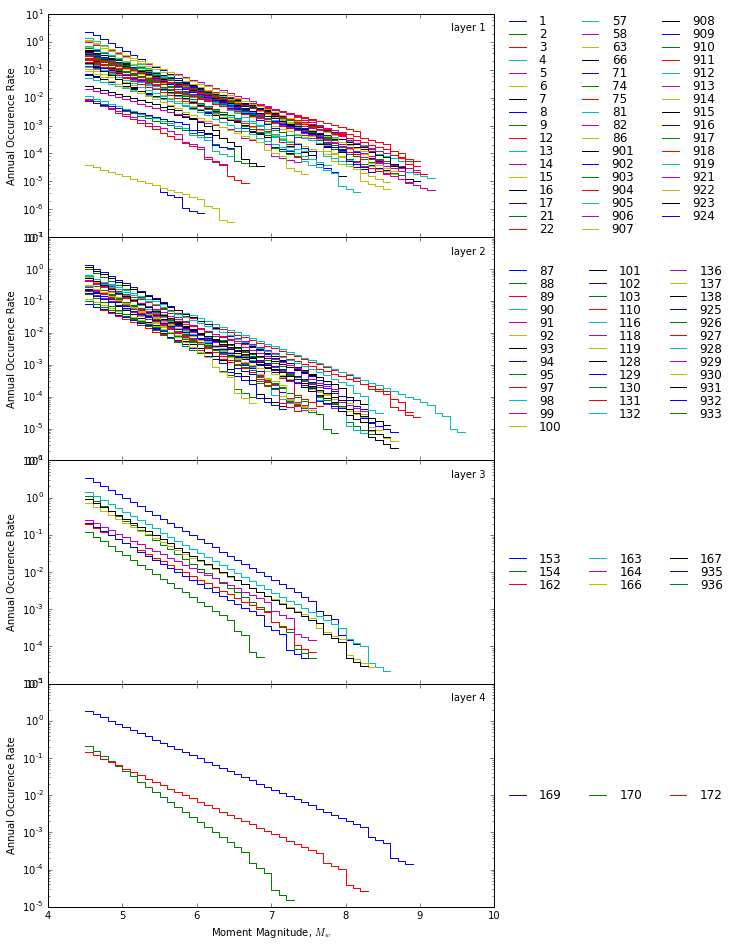

In [7]:
fig, axes = plt.subplots(len(LAYERS_DF.index), 1,
                         figsize=(8, 4*len(LAYERS_DF)),  sharex=True)
fig.subplots_adjust(hspace=0)
for layer_id, ax in zip(LAYERS_DF.index, axes):
    annotate('layer %d' % layer_id, ax=ax)
    layer_df = areal_collapsed_df[areal_collapsed_df['layerid'] == layer_id]
    for zoneid, zone in layer_df.iterrows():
        num_bins = zone['occurRates'].size
        mags = zone['mmin'] + zone['magBin']*np.arange(num_bins + 1)
        rates = zone['occurRates'][[0] + list(range(num_bins))]
        ax.step(mags, rates, label=zoneid)
    ax.set_yscale('log')
    ax.set_ylabel('Annual Occurence Rate')
    ax.legend(bbox_to_anchor=(1, 0.5), loc='center left',
              frameon=False, labelspacing=0, ncol=3)

axes[-1].set_xlabel('Moment Magnitude, $M_w$')
fig.savefig('MeanOccurrenceRatesAllZones.pdf',
            transparent=True, bbox_inches='tight', pad_inches=0.1)

# Query zones

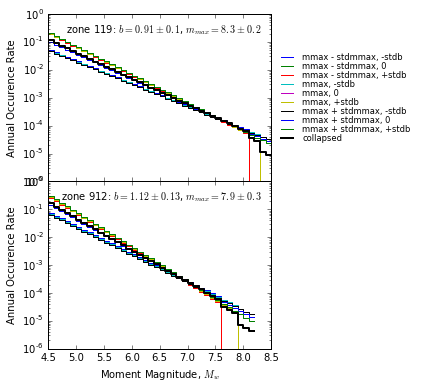

In [8]:
zoneids = [119, 912]
# zoneids = [1, 924, 93, 137, 913, 915, 132]
zones_df = areal_collapsed_df.loc[zoneids]

fig, axes = plt.subplots(len(zoneids), 1, figsize=(4, 3*len(zoneids)),
                         sharex=True)
fig.subplots_adjust(hspace=0)
for (zoneid, zone), ax in zip(zones_df.iterrows(), axes):
    annotate(r'zone %s: $b = %g \pm %g$, $m_{max} = %g \pm %g$' %
             (zoneid, zone['b'], zone['stdb'], zone['mmax'], zone['stdmmax']),
             ax=ax)
    zone_rates = zone.all_rates
    num_bins = zone.all_rates.shape[0]
    mags = zone['mmin'] + zone['magBin']*np.arange(zone.all_rates.shape[0] + 1)
    repeat_first = [0] + list(range(zone.all_rates.shape[0]))
    rates = zone.all_rates[repeat_first, :]
    for rate, label in zip(rates.T, labels):
        ax.step(mags, rate, label=label)
    ax.step(mags, zone['occurRates'][repeat_first],
            linewidth=2, color='black', label='collapsed')
    ax.set_yscale('log')
    ax.set_ylabel('Annual Occurence Rate')

axes[0].legend(bbox_to_anchor=(1, 0.5), loc='center left',
               frameon=False, labelspacing=0, fontsize='small')
axes[-1].set_xlabel('Moment Magnitude, $M_w$')

file_name = ('Mean_Occurrence_Rates_Zones_%s.pdf' %
             '_'.join([str(zoneid) for zoneid in zoneids]))
fig.savefig(file_name, transparent=True, bbox_inches='tight', pad_inches=0.1)

# Summarize

In [9]:
summary_columns = ['layerid', 'a', 'b', 'stdb', 'mmax', 'stdmmax',
                   'new style', 'tectonic subregion', 'region']

# TODO: move stuff like this into a jupyter notebook

print('\nSelected zones of interest:')
display(zones_df[summary_columns])

print('\nTop 3 b-value uncertainty:')
display(areal_collapsed_df.sort_values('stdb', ascending=False)[summary_columns].head(3))

print('\nTop 3 mmax uncertainty:')
display(areal_collapsed_df.sort_values('stdmmax', ascending=False)[summary_columns].head(3))

print('\nTop 3 mmax:')
display(areal_collapsed_df.sort_values('mmax', ascending=False)[summary_columns].head(3))

print('\nBottom 3 mmax:')
display(areal_collapsed_df.sort_values('mmax', ascending=True)[summary_columns].head(3))

print('\nTop 3 a-value:')
display(areal_collapsed_df.sort_values('a', ascending=False)[summary_columns].head(3))

print('\nBottom 3 a-value:')
display(areal_collapsed_df.sort_values('a', ascending=True)[summary_columns].head(3))

print('\nTop 3 b-value:')
display(areal_collapsed_df.sort_values('b', ascending=False)[summary_columns].head(3))

print('\nBottom 3 b-value:')
display(areal_collapsed_df.sort_values('b', ascending=True)[summary_columns].head(3))


Selected zones of interest:


,layerid,a,b,stdb,mmax,stdmmax,new style,tectonic subregion,region
zoneid,,,,,,,,,
119,2,3.81,0.91,0.10,8.3,0.2,reverse,intraplate margin lower,Shillong plateau
912,1,4.84,1.12,0.13,7.9,0.3,reverse,intraplate margin upper,Shillong plateau



Top 3 b-value uncertainty:


,layerid,a,b,stdb,mmax,stdmmax,new style,tectonic subregion,region
zoneid,,,,,,,,,
137,2,7.33,1.57,0.16,6.5,0.3,strike-slip,subduction interface,Andaman-Sumatra
913,1,4.35,0.93,0.14,8.8,0.4,strike-slip,active shallow crust strike-slip reverse,Bangladesh
915,1,5.73,1.36,0.14,6.6,0.3,normal,active shallow crust normal,Bay of Bengal



Top 3 mmax uncertainty:


,layerid,a,b,stdb,mmax,stdmmax,new style,tectonic subregion,region
zoneid,,,,,,,,,
1,1,5.20,1.05,0.07,8.0,0.4,strike-slip,subduction interface,Pamirs
89,2,5.29,1.11,0.06,7.3,0.4,reverse,subduction interface,Hindu Kush
92,2,4.80,1.05,0.10,8.3,0.4,strike-slip,subduction interface,Hindu Kush



Top 3 mmax:


,layerid,a,b,stdb,mmax,stdmmax,new style,tectonic subregion,region
zoneid,,,,,,,,,
132,2,4.40,0.87,0.06,9.4,0.2,reverse,subduction interface,Andaman-Sumatra
918,1,3.89,0.82,0.07,8.9,0.2,reverse,subduction interface,Andaman-Sumatra
110,2,3.58,0.78,0.06,8.8,0.2,reverse,subduction interface,Himalayas



Bottom 3 mmax:


,layerid,a,b,stdb,mmax,stdmmax,new style,tectonic subregion,region
zoneid,,,,,,,,,
71,1,0.00,0.81,0.05,5.8,0.3,undefined,no seismicity,Bay of Bengal & Arabian Sea
923,1,2.51,0.73,0.06,6.0,0.3,undefined,stable shallow crust,Peninsular India
82,1,3.14,1.01,0.13,6.1,0.3,reverse,stable shallow crust,Peninsular India



Top 3 a-value:


,layerid,a,b,stdb,mmax,stdmmax,new style,tectonic subregion,region
zoneid,,,,,,,,,
137,2,7.33,1.57,0.16,6.5,0.3,strike-slip,subduction interface,Andaman-Sumatra
909,1,7.08,1.37,0.12,7.6,0.3,normal,active shallow crust normal,Tibetan plateau
57,1,6.79,1.35,0.10,7.2,0.4,normal,active shallow crust normal,Andaman-Sumatra



Bottom 3 a-value:


,layerid,a,b,stdb,mmax,stdmmax,new style,tectonic subregion,region
zoneid,,,,,,,,,
71,1,0.00,0.81,0.05,5.8,0.3,undefined,no seismicity,Bay of Bengal & Arabian Sea
86,1,0.00,0.81,0.05,6.3,0.2,undefined,no seismicity,"Sri Lanka, Laccadive Sea"
924,1,1.58,0.63,0.10,6.2,0.3,undefined,stable shallow crust,Peninsular India



Top 3 b-value:


,layerid,a,b,stdb,mmax,stdmmax,new style,tectonic subregion,region
zoneid,,,,,,,,,
137,2,7.33,1.57,0.16,6.5,0.3,strike-slip,subduction interface,Andaman-Sumatra
909,1,7.08,1.37,0.12,7.6,0.3,normal,active shallow crust normal,Tibetan plateau
915,1,5.73,1.36,0.14,6.6,0.3,normal,active shallow crust normal,Bay of Bengal



Bottom 3 b-value:


,layerid,a,b,stdb,mmax,stdmmax,new style,tectonic subregion,region
zoneid,,,,,,,,,
924,1,1.58,0.63,0.10,6.2,0.3,undefined,stable shallow crust,Peninsular India
919,1,2.73,0.72,0.10,7.2,0.3,reverse,stable shallow crust,Peninsular India
14,1,3.12,0.72,0.09,8.6,0.4,strike-slip,subduction interface,Makran
